# Method LRP

In [1]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
from tensorflow.keras import Model

import matplotlib.pyplot as plt
import numpy as np

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
(train_images, train_labels), (test_images, test_labels) = datasets.fashion_mnist.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

train_images = train_images.reshape((train_images.shape[0], 28, 28, 1))
test_images = test_images.reshape((test_images.shape[0], 28, 28, 1))

4423680/4422102 [==============================] - 0s 0us/step


In [4]:
train_images = train_images.reshape((train_images.shape[0], 28, 28, 1))
test_images = test_images.reshape((test_images.shape[0], 28, 28, 1))

In [5]:
x = layers.Input((28, 28, 1), name='input_layer')
y = layers.Conv2D(32, (3, 3), activation='relu')(x)
y = layers.MaxPooling2D((2, 2))(y)
y = layers.Conv2D(64, (3, 3), activation='relu')(y)
y = layers.MaxPooling2D((2, 2))(y)
y = layers.Conv2D(64, (3, 3), activation='relu')(y)
y = layers.Flatten()(y)
y = layers.Dense(64, activation='relu')(y)
y = layers.Dense(10)(y)
model = Model(x, y)

In [6]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=5, 
                    validation_data=(test_images, test_labels))

Epoch 1/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4976 - accuracy: 0.8179 - val_loss: 0.3700 - val_accuracy: 0.8691
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3267 - accuracy: 0.8809 - val_loss: 0.3337 - val_accuracy: 0.8802
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2793 - accuracy: 0.8975 - val_loss: 0.3307 - val_accuracy: 0.8798
Epoch 4/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2498 - accuracy: 0.9079 - val_loss: 0.2857 - val_accuracy: 0.8980
Epoch 5/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2235 - accuracy: 0.9169 - val_loss: 0.2773 - val_accuracy: 0.8980


In [115]:
from tensorflow.python.ops import nn_ops, gen_nn_ops

class LRP:
    def __init__(self, model, index):
        self._layers = model.layers
        self._input = model.layers[0]
        self.alpha = 2
        self.name = 'lrp'
        self._model = Model(model.input, self.get_lrp_backprop(index))
        
    
    def analyze(self, images):
        return self._model(images)
        
        
    def get_lrp_backprop(self, index):
        layers = self._layers
        layers.reverse()
        
        with tf.name_scope(self.name):
            Rs = []

            for i in range(len(self._layers) - 1):
                print(layers[i].name)

                if i is 0:
                    Rs.append(tf.maximum(0., layers[i].output))
                    Rs.append(self.backprop_dense(layers[i], layers[i+1], Rs[-1]))
                elif 'dense' in layers[i].name.lower():
                    Rs.append(self.backprop_dense(layers[i], layers[i+1], Rs[-1]))
                elif 'flatten' in layers[i].name.lower():
                    Rs.append(self.flatten_conv(layers[i], Rs[-1]))
                elif 'conv' in layers[i].name.lower():
                    Rs.append(self.backprop_conv(layers[i], layers[i+1], Rs[-1]))
                elif 'pooling' in layers[i].name.lower():
                    Rs.append(self.backprop_pool(layers[i], layers[i+1], Rs[-1]))
                else:
                    raise Error('Unknown operation.')

            return Rs[-1]
        
        
    def backprop_dense(self, layer, next_layer, relevance):
        weights, bias = layer.get_weights()
        W_p = tf.maximum(0., weights)
        b_p = tf.maximum(0., bias)
        z_p = tf.matmul(next_layer.output, W_p) + b_p
        s_p = relevance / z_p
        c_p = tf.matmul(s_p, tf.transpose(W_p))

        W_n = tf.minimum(0., weights)
        b_n = tf.minimum(0., bias)
        z_n = tf.matmul(next_layer.output, W_n) + b_n
        s_n = relevance / z_n
        c_n = tf.matmul(s_n, tf.transpose(W_n))
        
        return next_layer.output * (self.alpha * c_p + (1 - self.alpha) * c_n)
    
    def backprop_conv(self, layer, next_layer, relevance):
        weights, bias = layer.get_weights()
        strides = [1,1,1,1]
        padding = layer.padding.upper()
        W_p = tf.maximum(0., weights)
        b_p = tf.maximum(0., bias)
        z_p = nn_ops.conv2d(next_layer.output, W_p, strides, padding) + b_p
        s_p = relevance / z_p
        c_p = nn_ops.conv2d_backprop_input(tf.shape(next_layer.output), W_p, s_p, strides, padding)

        W_n = tf.minimum(0., weights)
        b_n = tf.minimum(0., bias)
        z_n = nn_ops.conv2d(next_layer.output, W_n, strides, padding) + b_n
        s_n = relevance / z_n
        c_n = nn_ops.conv2d_backprop_input(tf.shape(next_layer.output), W_n, s_n, strides, padding)

        return next_layer.output * (self.alpha * c_p + (1 - self.alpha) * c_n)
    
    
    def backprop_pool(self, layer, next_layer, relevance):
        
        strides = [1,2,2,1]
        padding = layer.padding.upper()
        ksize = [1,2,2,1] 

        if 'avg' in layer.name.lower():
            z = nn_ops.avg_pool(next_layer.output, ksize, strides, padding) + 1e-10
            s = relevance / z
            c = gen_nn_ops._avg_pool_grad(tf.shape(next_layer.output), s, ksize, strides, padding)
            return next_layer.output * c
        else:
            z = nn_ops.max_pool(next_layer.output, ksize, strides, padding) + 1e-10
            s = relevance / z
            c = gen_nn_ops.max_pool_grad_v2(next_layer.output, z, s, ksize, strides, padding)
            return next_layer.output * c
    
    def flatten_conv(self, layer, relevance):
        
        shape = layer.input.get_shape().as_list()
        shape[0] = -1
        return tf.reshape(relevance, shape)
        

In [116]:
lrp = LRP(model)

dense_1
dense
flatten
conv2d_2
max_pooling2d_1
conv2d_1
max_pooling2d
conv2d


In [117]:
a = lrp.analyze(test_images[:25])

In [118]:
a[0]

<tf.Tensor: shape=(28, 28, 1), dtype=float32, numpy=
array([[[            nan],
        [            nan],
        [            nan],
        [            nan],
        [            nan],
        [            nan],
        [            nan],
        [            nan],
        [            nan],
        [            nan],
        [            nan],
        [            nan],
        [            nan],
        [            nan],
        [            nan],
        [            nan],
        [            nan],
        [            nan],
        [            nan],
        [            nan],
        [            nan],
        [            nan],
        [            nan],
        [            nan],
        [            nan],
        [            nan],
        [            nan],
        [            nan]],

       [[            nan],
        [            nan],
        [            nan],
        [            nan],
        [            nan],
        [            nan],
        [            nan],


In [36]:
test_labels[0]

9

In [126]:
a = tf.constant([[0.3, 0.5, 0.79, 0.2, 0.11],[0.3, 0.5, 0.80, 0.2, 0.11]])
cond = tf.equal(a, tf.reduce_max(a))
tf.where(cond, a, tf.zeros_like(a))

<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
array([[0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0.8, 0. , 0. ]], dtype=float32)>

In [130]:
tf.reduce_max(a, 1)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.79, 0.8 ], dtype=float32)>

In [131]:
tf.equal(a, tf.reduce_max(a, 1), axis = 1)

TypeError: equal() got an unexpected keyword argument 'axis'

In [133]:
tf.argmax(a, 1)

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([2, 2])>

In [134]:
tf.boolean_mask(a, tf.argmax(a, 1))

<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
array([[0.3 , 0.5 , 0.79, 0.2 , 0.11],
       [0.3 , 0.5 , 0.8 , 0.2 , 0.11]], dtype=float32)>

In [148]:
indices = tf.constant([[[1]], [[2]]])
updates = tf.constant([9, 10])
shape = tf.constant([2, 5])
scatter = tf.scatter_nd(indices, updates, shape)
print(scatter)

InvalidArgumentError: Outer dimensions of indices and update must match. Indices shape: [2,1,1], updates shape:[2] [Op:ScatterNd]

In [150]:
indices = tf.constant([[0], [2]])
updates = tf.constant([[[5, 5, 5, 5], [6, 6, 6, 6],
                        [7, 7, 7, 7], [8, 8, 8, 8]],
                       [[5, 5, 5, 5], [6, 6, 6, 6],
                        [7, 7, 7, 7], [8, 8, 8, 8]]])
shape = tf.constant([4, 4, 4])
scatter = tf.scatter_nd(indices, updates, shape)
print(scatter)

tf.Tensor(
[[[5 5 5 5]
  [6 6 6 6]
  [7 7 7 7]
  [8 8 8 8]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[5 5 5 5]
  [6 6 6 6]
  [7 7 7 7]
  [8 8 8 8]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]], shape=(4, 4, 4), dtype=int32)


In [59]:
model.layers

In [68]:
model.layers[2].output

<tf.Tensor 'max_pooling2d/MaxPool:0' shape=(None, 13, 13, 32) dtype=float32>

In [67]:
model.layers[3].weights[0].shape

TensorShape([3, 3, 32, 64])

In [95]:
zp = tf.matmul(tf.constant([[1,2,3]]), tf.constant([[2,1],[2,2],[2,3]]))

In [96]:
sp = tf.constant([20,-22]) / zp

In [97]:
sp

<tf.Tensor: shape=(1, 2), dtype=float64, numpy=array([[ 1.66666667, -1.57142857]])>

In [98]:
tf.transpose(tf.constant([[2,1],[2,2],[2,3]]))

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[2, 2, 2],
       [1, 2, 3]], dtype=int32)>

In [99]:
tf.matmul(sp, tf.transpose(tf.constant([[2,1],[2,2],[2,3]], dtype=tf.float64))) * [1,2,3]

<tf.Tensor: shape=(1, 3), dtype=float64, numpy=array([[ 1.76190476,  0.38095238, -4.14285714]])>

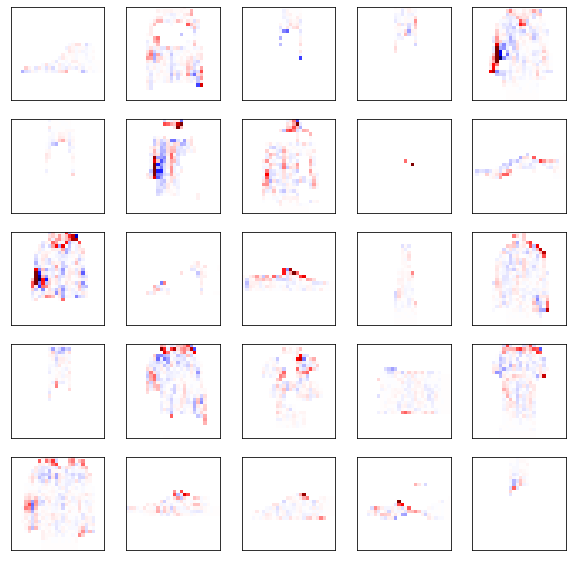

In [119]:
vmax = np.max(a)
vmin = np.max(a)
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(a[i,:,:,0], cmap="seismic", clim=(-1, 1))
plt.show()